# Dentre os parâmetros, altura, quantidade de bloqueio, porcentagem de lances livres e assistência, como esses estão associados a média de pontos de um jogador de basquete?



###  <font color=red> Emanuelle Moço e Giovana Lemes </font>

### O objetivo deste projeto é, por meio de regressão linear, responder a  pergunta acima. Como base utilizamos o dataset "NBA Players stats since 1950", disponível no site kaggle. 
### Para isso iremos analisar as seguintes variáveis:
#### - Height (altura) 
#### - PTS (pontuação do jogador durante a temporada)
#### - Player (nome do jogador)
#### - G (quantidade de jogos durante a temporada)
#### - FT% (porcentagem de lances livres)
#### - BLK (quantidade de bloqueios)

In [1]:
%matplotlib notebook
%reset -f
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cmath
plt.style.use('ggplot')

import itertools
import pylab
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr
from matplotlib import cm
import statsmodels.api as sm1 #Usa OLS com X como matriz de planejamento
import statsmodels.formula.api as sm  #Usa OLS como no R
from statsmodels.formula.api import ols
import scipy
from scipy.stats import norm


C:\Users\giiol\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#! explorer . 

In [3]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\giiol\Desktop\proj 3\cd_projeto3


In [4]:
#Se usar o arquivo descompactado
dados1 = pd.read_table('Players.csv', encoding="latin1",sep=',')
dados2 = pd.read_table('Seasons_Stats.csv', encoding="latin1",sep=',')
    

### Vale ressaltar que o nosso dataframe possui o mesmo jogador diversas vezes pois ele está descrito por cada temporada (anual). 

#### Qual posição tem mais informações? (vamos analisar a que tiver mais informações)

In [60]:
print ("F: {0}".format(len(dados2[dados2.Pos == "F"])))
print ("C: {0}".format(len(dados2[dados2.Pos == "C"])))
print ("G: {0}".format(len(dados2[dados2.Pos == "G"])))
print ("G-F: {0}".format(len(dados2[dados2.Pos == "G-F"])))
print ("F-C: {0}".format(len(dados2[dados2.Pos == "F-C"])))
print ("F-G: {0}".format(len(dados2[dados2.Pos == "F-G"])))
print ("PG: {0}".format(len(dados2[dados2.Pos == "PG"])))
print ("PF: {0}".format(len(dados2[dados2.Pos == "PF"])))
print ("SF: {0}".format(len(dados2[dados2.Pos == "SF"])))
print ("SG: {0}".format(len(dados2[dados2.Pos == "SG"])))

F: 123
C: 4759
G: 139
G-F: 79
F-C: 81
F-G: 60
PG: 4648
PF: 4966
SF: 4699
SG: 4811


### Podemos observar que a posição com mais informações é a "PF", que representa Pivô, então vamos analisar os dados somente dos mesmos

### A análise de uma única posição do basquete, auxilia para que os dados obtidos sejam mais coerentes, dado que cada uma exerce funções diferentes.

In [61]:
#limpar a primeira tabela para que tenha apenas as variáveis que vamos utilizar
dados1 = dados1.loc[:,["Player", "height"]]  
dados1.head()

,Player,height
0,Curly Armstrong,180.0
1,Cliff Barker,188.0
2,Leo Barnhorst,193.0
3,Ed Bartels,196.0
4,Ralph Beard,178.0


In [62]:
#para saber todas as colunas da tabela dados2
dados2.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [63]:
#tabela com dados dos pivos "PF"
tabela_PF = dados2[dados2.Pos == "PF"]

In [64]:
#apagar os dados nulos da altura
dados1 = dados1.loc[pd.notnull(dados1.height),:]

In [65]:
#modificando a tabela_PF para ter apenas os dados que são uteis para nós(ou que poderão ser)
#G = games
#FT% = porcentagem de acertos (acertos/quanto tentou)
#AST = assistências 
#PTS = pontos 
tabela_PF = tabela_PF.loc[:,["Player", "G", "FT%",  "AST", "PTS" , "BLK"]]  

In [66]:
df = tabela_PF.set_index('Player').join(dados1.set_index('Player'), how='inner', lsuffix='tabela_PF',rsuffix='dados1')


In [67]:
df.head()

,G,FT%,AST,PTS,BLK,height
Player,,,,,,
A.C. Green,82.0,0.611,54.0,521.0,49.0,203.0
A.C. Green,79.0,0.780,84.0,852.0,80.0,203.0
A.C. Green,82.0,0.773,93.0,937.0,45.0,203.0
A.C. Green,82.0,0.786,103.0,1088.0,55.0,203.0
A.C. Green,82.0,0.751,90.0,1061.0,50.0,203.0


### Criando uma coluna para a média de pontos que cada jogador faz durante a temporada, dado que o dataframe nos fornece a quantidade total de pontos e a quantidade de jogos por temporada.
### media = (quantidade de pontos)/(quantidade de jogos)

In [68]:
media = df.loc[(df.G!=0), 'm_ponto'] = df.PTS/df.G

In [69]:
#eliminando os dados nulos
df = df.loc[pd.notnull(df.m_ponto),:]
df = df.loc[pd.notnull(df.height),:]

In [70]:
import numpy as np
import statsmodels.api as sm

Y = df["m_ponto"]
X = df["height"]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                m_ponto   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.07597
Date:                Tue, 21 Nov 2017   Prob (F-statistic):              0.783
Time:                        16:28:16   Log-Likelihood:                -15820.
No. Observations:                4966   AIC:                         3.164e+04
Df Residuals:                    4964   BIC:                         3.166e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.0399      3.433      2.633      0.008       2.310      15.770
height        -0.0046      0.017     -0.276      0.783      -0.038       0.028
==============================================================================
Omnibus:                      572.347   Durbin-Watson:                   0.537
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              785.829
Skew:                           0.958   Prob(JB):                    2.29e-171
Kurtosis:                       3.361   Cond. No.                     8.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Percebemos que não há relevância entre altura e a quantidade de pontos feita dado que R² = 0.

### Como não houve uma considerável relação entre a altura e a quantidade de pontos, vamos analisar se existe alguma relação entre a quantidade de bloqueios e a média de pontos.


In [71]:
df = df.loc[pd.notnull(df.BLK),:]

In [72]:
df['lnBLK'] = np.log(df['BLK'])

C:\Users\giiol\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


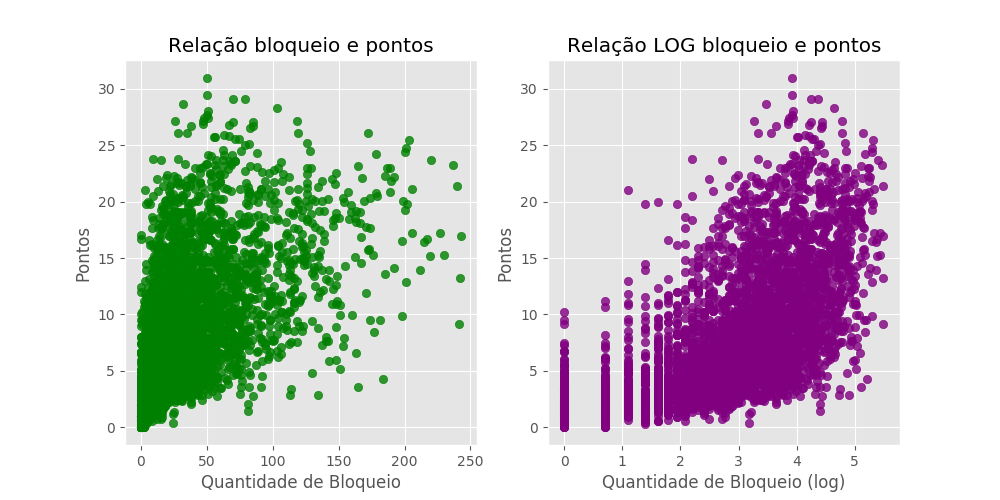

In [73]:
hmax = df.height.max()
hmin = df.height.min()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(df.BLK, df.m_ponto, c='green', alpha=0.8)
plt.title("Relação bloqueio e pontos")
plt.xlabel("Quantidade de Bloqueio")
plt.ylabel("Pontos")
plt.subplot(122)
plt.scatter(df.lnBLK, df.m_ponto, c='purple', alpha=0.8)
plt.title("Relação LOG bloqueio e pontos")
plt.xlabel("Quantidade de Bloqueio (log)")
plt.ylabel("Pontos")
plt.show()

### Analisando a relação somente entre o bloqueio e pontos médios, conseguimos ver que existe uma dependência entre ambos.
### Então,  vamos analisar se existe relação entre a altura,  quantidade de bloqueios e a pontuação média de cada jogador.
### Para isso, faremos uma regressão múltipla.

In [75]:
df.columns

Index(['G', 'FT%', 'AST', 'PTS', 'BLK', 'height', 'm_ponto', 'lnBLK'], dtype='object')

In [76]:
colunas = ['G', 'FT%', 'AST', 'PTS', 'BLK', 'm_ponto', 'height',
       'weight']

In [77]:
colunas = [ 'BLK',  'height']


In [78]:
Y = df["m_ponto"]
X = df.loc[:, colunas]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                m_ponto   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     1177.
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:28:24   Log-Likelihood:                -12713.
No. Observations:                4294   AIC:                         2.543e+04
Df Residuals:                    4291   BIC:                         2.545e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.5313      2.996      6.520      0.000      13.658      25.405
BLK            0.0956      0.002     48.476      0.000       0.092       0.100
height        -0.0716      0.015     -4.889      0.000      -0.100      -0.043
==============================================================================
Omnibus:                      721.402   Durbin-Watson:                   0.623
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1307.656
Skew:                           1.060   Prob(JB):                    1.11e-284
Kurtosis:                       4.677   Cond. No.                     8.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
p = itertools.permutations(colunas)

In [80]:
blk = df["BLK"].max()
height_max = df["height"].max()
AST_max = df['AST'].max()
ft_max = df['FT%'].max()

<IPython.core.display.Javascript object>


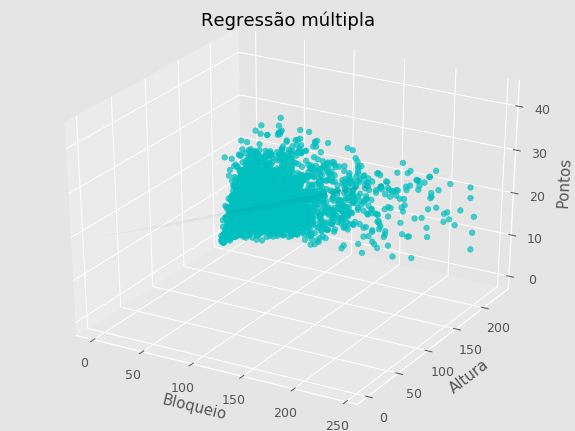

C:\Users\giiol\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [101]:
fig = pylab.figure()
ax = Axes3D(fig)
model = ols(formula='m_ponto ~ BLK + height', data = df)
fit = model.fit()
fit.summary()


x_surf = np.arange(0, blk, 2)                # generate a mesh
y_surf = np.arange(0, height_max, 0.5)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

exog = pd.core.frame.DataFrame({'BLK': x_surf.ravel(), 'height': y_surf.ravel()})
out = fit.predict(exog = exog)
ax.plot_surface(x_surf, y_surf,
                out.reshape(x_surf.shape),
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.1)

ax.scatter(df['BLK'], df['height'], df['m_ponto'],
           c='c',
           marker='o',
           alpha=0.7)

ax.set_xlabel('Bloqueio')
ax.set_ylabel('Altura')
ax.set_zlabel('Pontos')
plt.title("Regressão múltipla")

plt.show()


### Percebe-se que há uma dependência entre a altura, o bloqueio e a quantidade média de pontos que um jogador vai, visto que o valor de R² = 0.354. Também é possível perceber essa relação pelo gráfico acima.

### Para uma melhor análise dessa relação, utilizaremos a variável altura em sua forma logarítima:



In [82]:
df['lnheight'] = np.log(df['height'])
df.head()
lnheight_max = df["lnheight"].max()

<IPython.core.display.Javascript object>


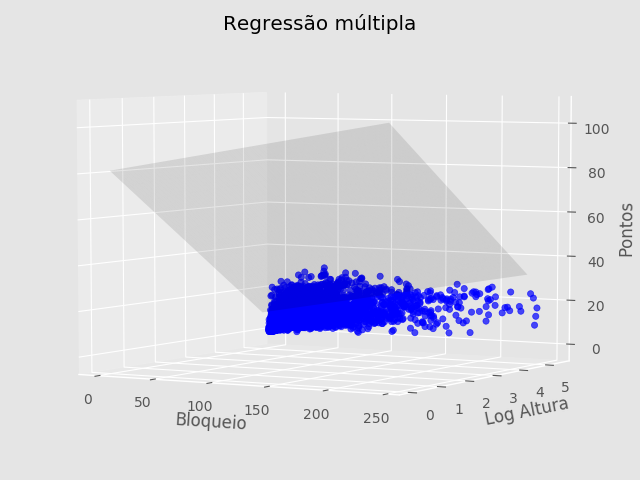

C:\Users\giiol\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [83]:
fig = pylab.figure()
ax = Axes3D(fig)
model = ols(formula='m_ponto ~ BLK + lnheight', data = df)
fit = model.fit()
fit.summary()

#fig = plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')

x_surf = np.arange(0, blk, 2)                # generate a mesh
y_surf = np.arange(0, lnheight_max, 0.5)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

exog = pd.core.frame.DataFrame({'BLK': x_surf.ravel(), 'lnheight': y_surf.ravel()})
out = fit.predict(exog = exog)
ax.plot_surface(x_surf, y_surf,
                out.reshape(x_surf.shape),
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.1)

ax.scatter(df['BLK'], df['lnheight'], df['m_ponto'],
           c='blue',
           marker='o',
           alpha=0.7)

ax.set_xlabel('Bloqueio')
ax.set_ylabel('Log Altura')
ax.set_zlabel('Pontos')
plt.title("Regressão múltipla")

ax.view_init(5)

plt.show()


In [84]:
colunasln = [ 'BLK',  'lnheight']

In [103]:
import numpy as np
import statsmodels.api as sm

Y = df["m_ponto"]
X = df.loc[:, colunasln]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                m_ponto   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     1176.
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:41:17   Log-Likelihood:                -12713.
No. Observations:                4294   AIC:                         2.543e+04
Df Residuals:                    4291   BIC:                         2.545e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.2058     15.708      5.170      0.000      50.410     112.002
BLK            0.0956      0.002     48.475      0.000       0.092       0.099
lnheight     -14.3426      2.952     -4.858      0.000     -20.130      -8.555
==============================================================================
Omnibus:                      721.755   Durbin-Watson:                   0.623
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1308.408
Skew:                           1.061   Prob(JB):                    7.64e-285
Kurtosis:                       4.677   Cond. No.                     1.08e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Para concluir se essa relação é realmente válida, vamos análisar o resíduo da análise:

<IPython.core.display.Javascript object>


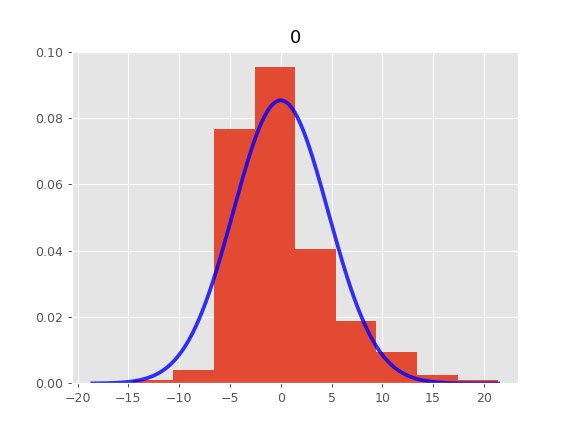

In [104]:
from scipy.stats import norm
from scipy import stats
var = df.var()
sigma = var**(0.5)

x = df.BLK
y = df.lnheight
z = df.m_ponto
e = z - (results.params.const+ results.params.BLK*x + results.params.lnheight * y)
e

rec = np.arange(e.min(),e.max(), 0.01)
pd.DataFrame(e).hist(normed=True)
(loc, scale) = stats.norm.fit(e)
plt.plot(rec , stats.norm.pdf(rec, loc = loc, scale =scale), 'b', lw = 3, alpha = 0.8)


## Podemos perceber que o histograma dos resíduos apresenta um formato próximo ao de uma normal. Segundo o teste de normalidade, quanto mais similar a uma normal for o resíduo, melhor é o teste de regressão.


## Agora vamos fazer regressão utilizando outra técnica do pacote ols:

In [105]:
#correlação entre as variáveis
df.corr(method = "pearson")

,G,FT%,AST,PTS,BLK,height,m_ponto,lnBLK,lnheight
G,1.000000,0.230339,0.658600,0.734629,0.602272,-0.000047,0.555029,0.771731,-0.000766
FT%,0.230339,1.000000,0.221898,0.280157,0.108572,0.028470,0.307088,0.161172,0.026755
AST,0.658600,0.221898,1.000000,0.842760,0.569056,-0.003668,0.762973,0.589441,-0.004122
PTS,0.734629,0.280157,0.842760,1.000000,0.674499,0.017545,0.923757,0.687314,0.016147
BLK,0.602272,0.108572,0.569056,0.674499,1.000000,0.137647,0.592090,0.805204,0.134518
height,-0.000047,0.028470,-0.003668,0.017545,0.137647,1.000000,0.022092,0.099570,0.999602
m_ponto,0.555029,0.307088,0.762973,0.923757,0.592090,0.022092,1.000000,0.612981,0.020584
lnBLK,0.771731,0.161172,0.589441,0.687314,0.805204,0.099570,0.612981,1.000000,0.096510
lnheight,-0.000766,0.026755,-0.004122,0.016147,0.134518,0.999602,0.020584,0.096510,1.000000


### A escolha das próximas variáveis, foram feitas, levando em conta os valores de correlação observados acima.

In [114]:
coluna = ['height','AST','BLK']

In [115]:
import numpy as np
import statsmodels.api as sm

Y = df["m_ponto"]
X = df.loc[:, coluna]
X = sm.add_constant(X)
model = sm.OLS(Y,X, missing = 'drop')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                m_ponto   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     2324.
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:48:57   Log-Likelihood:                -11580.
No. Observations:                4294   AIC:                         2.317e+04
Df Residuals:                    4290   BIC:                         2.319e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3116      2.316      2.294      0.022       0.772       9.852
height        -0.0094      0.011     -0.834      0.404      -0.032       0.013
AST            0.0474      0.001     54.620      0.000       0.046       0.049
BLK            0.0375      0.002     20.225      0.000       0.034       0.041
==============================================================================
Omnibus:                      646.226   Durbin-Watson:                   0.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1880.177
Skew:                           0.794   Prob(JB):                         0.00
Kurtosis:                       5.826   Cond. No.                     9.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Percebemos que a correlação entre a altura, assistência, bloqueio e a média de pontos, é de 61.9%

### Agora vamos analisar a correlação entre todas as variáveis abaixo:

In [116]:
coluna2 = ['height','AST','BLK','FT%']

In [117]:
import numpy as np
import statsmodels.api as sm

Y = df["m_ponto"]
X = df.loc[:, coluna2]
X = sm.add_constant(X)
model = sm.OLS(Y,X, missing = 'drop')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                m_ponto   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     1734.
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:51:44   Log-Likelihood:                -11051.
No. Observations:                4129   AIC:                         2.211e+04
Df Residuals:                    4124   BIC:                         2.214e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5699      2.320      1.108      0.268      -1.979       7.118
height        -0.0147      0.011     -1.301      0.193      -0.037       0.007
AST            0.0440      0.001     50.395      0.000       0.042       0.046
BLK            0.0367      0.002     20.143      0.000       0.033       0.040
FT%            6.0823      0.393     15.461      0.000       5.311       6.854
==============================================================================
Omnibus:                      564.440   Durbin-Watson:                   0.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1429.752
Skew:                           0.767   Prob(JB):                    3.41e-311
Kurtosis:                       5.440   Cond. No.                     9.41e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Deste modo, temos que a correlação entre a altura, assistência, bloqueio e a média de pontos, é de 62.7%, ou seja, a porcentagem de lances livres não causa uma grande influência nesta relação.

### Para termos uma noção da real relação que a assistência exerce sobre a média de pontos, realizamos uma regressão múltipla mantendo a altura e alterando a variável bloqueio para a de assistência (AST).

In [118]:
coluna3 = ['height','AST']

In [111]:
import numpy as np
import statsmodels.api as sm

Y = df["m_ponto"]
X = df.loc[:, coluna3]
X = sm.add_constant(X)
model = sm.OLS(Y,X, missing = 'drop')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                m_ponto   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2996.
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        16:45:20   Log-Likelihood:                -11775.
No. Observations:                4294   AIC:                         2.356e+04
Df Residuals:                    4291   BIC:                         2.358e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1820      2.392     -0.912      0.362      -6.872       2.508
height         0.0294      0.012      2.524      0.012       0.007       0.052
AST            0.0575      0.001     77.382      0.000       0.056       0.059
==============================================================================
Omnibus:                      521.445   Durbin-Watson:                   0.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1503.383
Skew:                           0.651   Prob(JB):                         0.00
Kurtosis:                       5.590   Cond. No.                     9.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>


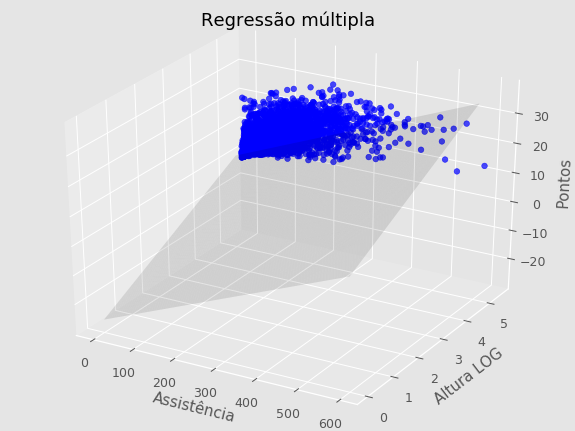

C:\Users\giiol\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [112]:
fig = pylab.figure()
ax = Axes3D(fig)
model = ols(formula='m_ponto ~ AST + lnheight', data = df)
fit = model.fit()
fit.summary()

#fig = plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')

x_surf = np.arange(0, AST_max, 2)                # generate a mesh
y_surf = np.arange(0, lnheight_max, 0.5)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

exog = pd.core.frame.DataFrame({'AST': x_surf.ravel(), 'lnheight': y_surf.ravel()})
out = fit.predict(exog = exog)
ax.plot_surface(x_surf, y_surf,
                out.reshape(x_surf.shape),
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.1)

ax.scatter(df['AST'], df['lnheight'], df['m_ponto'],
           c='blue',
           marker='o',
           alpha=0.7)
ax.set_xlabel('Assistência')
ax.set_ylabel('Altura LOG')
ax.set_zlabel('Pontos')
plt.title("Regressão múltipla")


plt.show()


### Considerações finais:

   Retomando a pergunta inicial, dentre os parâmetros, altura, quantidade de bloqueio, porcentagem de lances livres e assistência, como esses estão associados a média de pontos de um jogador de basquete?
   Podemos concluir que todas essas variáveis juntas exercem um forte nível de associação. Inicialmente procuramos analisar de maneira individual como cada uma se comportava diante de uma regressão linear, assim observamos que a variável altura por si, não possuía uma associação, ou seja, não rejeitamos H0.Após essa constatação resolvemos realizar uma regressão múltipla entre altura e bloqueio, optando por sempre utilizar a variável altura como base nas análises. Nessa última, obtivemos uma associação de 35,4% (segundo o R²). Portando, pode-se dizer que o bloqueio e a altura juntos possuem significante nivel associativo quando relacionado a média de ponto. 
   Segundo o teste de normalidade em uma regressão que podemos rejeitar o valor de H0, o resíduo apresenta formato de uma normal e quanto maior for a similaridade com esse formato, melhor será a relação entre a variável endógena e exógena. No caso da regressão múltipla entre altura, bloqueio e pontos, o histograma normalizado do resíduo, quando comparado a uma normal apresenta semelhança aparente com a mesma, afirmando a análise feita através do sumário. 
   Para um melhor desenvolvimento do projeto, optamos por fazer a correlação entre as variáveis de uma maneira diferente da feita anteriormente, assim foi possivel escolher para a análise as variáveis com maiores correlações em relação a média dos pontos. Escolhemos as variáveis 'AST'(assistência) e 'FT%' (porcentagem de lances livres). Com isso, realizamos regressão múltipla entre altura, assistência, bloqueio e média dos pontos, obtendo um alto nível de associação (61,9%). Ao inserirmos a porcentagem de lances livres nessa regressão, afim de utilizar todas as variáveis com maior correlação, obtivemos um nivel de associação de 62,7%, ou seja, é possível perceber que a porcentagem de lances livres não gera expressiva influência no resultado quando associada as outras.
   Dessa forma, para examinar melhor a relação entre a assistencia e a média de pontos, executamos uma regressão entre altura (variável base escolhida), média dos pontos e assistência, obtendo um nivel de significância correspondente a 58,3%, ou seja, um resultado melhor quando comparado a primeira regressão feita somente com o bloqueio. Podemos concluir que a assistencia dentre as variáveis bloqueio e porcentagem de lances livre é a que mais possui caráter influenciador sobre a média dos pontos.
   
  

## + Adicional: Texto explicando o que cada aluno fez:

### A distribuição de tarefas foi feita de maneira igualitária entre as duas integrantes do grupo.  Todo o projeto foi feito em conjunto durante as aulas, atendimentos e horários extras no Insper. Inicialmente, ambas pesquisaram sobre temas que poderiam ser relevantes para o trabalho no site “Kaggle”. Após filtragem dos dados foi escolhido o dataset “NBA Players stats since 1950”.

